# Monocular Depth Dataset Tutorial

Here is a simple tutorial to create a sparse depth map dataset for monocular depth estimation. The ground truth depth maps are created from lidar point clouds. 
This tutorial requires the [Argoverse 3D Tracking v1.1](https://www.argoverse.org/data.html) dataset and the [Argoverse API](https://github.com/argoai/argoverse-api). Please check [here](https://github.com/argoai/argoverse-api) for instructions on how to install it.

In [1]:
import fnmatch
import glob
import os
from typing import Optional, Tuple

import cv2
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm

from argoverse.data_loading.argoverse_tracking_loader import ArgoverseTrackingLoader
from argoverse.utils.camera_stats import RING_CAMERA_LIST

#### NOTE:

1. We'll define and use the **Lidar2Depth class** to project all Argoverse LiDAR sweeps onto corresponding ring camera images to obtain sparse depth ground truth. We'll instantiate this class once for each log.

2. Ground truth could be stored in a variety of formats, but we'll store integer-discretized depth as depth*256, to increase the range `from ~0.004 meters to 255.996 meters (uint16_max/256)`.

3. 0 meters is a privileged value that represents null ground truth. Unlike KITTI, we store depth, as opposed to disparity maps.

In [2]:
class Lidar2Depth:
    """
    Convert 360 degree LiDAR point cloud to depth map corresponding to each ring camera
    for monocular depth estimation.

    To use:
    >>> input_log_dir = "path/to/3d20ae25-5b29-320d-8bae-f03e9dc177b9/"
    >>> output_save_path = "path/to/depth_dataset/"
    >>> Lidar2Depth(input_log_dir, output_save_path)  
    """

    def __init__(self, input_log_dir: str, output_save_path: str) -> None:

        self.input_log_dir = input_log_dir
        self.output_save_path = output_save_path
        self.log_id = os.path.basename(input_log_dir)
        print("Log ID ", self.log_id)

        # Load Argoverse 3D Tracking dataset
        dataset = os.path.dirname(self.input_log_dir)
        self.argoverse_loader = ArgoverseTrackingLoader(dataset)
        self.argoverse_data = self.argoverse_loader.get(self.log_id)

        # Count the number of LiDAR ply files in the log dir
        self.lidar_frame_counter = len(
            glob.glob1(os.path.join(self.input_log_dir, "lidar"), "*.ply")
        )

        # Setup depth dataset dir
        self.depth_data_dir_setup()

        # Extract depth data and ring camera frames
        self.depth_extraction()

    def depth_data_dir_setup(self) -> None:
        """
        Depth dataset structure
        +-- train/val/test
        |   +-- depth
        |   |   +-- 00c561b9-2057-358d-82c6-5b06d76cebcf
        |   |   |   +-- ring_front_center
        |   |   |   |   +-- 1.png
        |   |   |   |   +-- 2.png
        |   |   |   |   +--   .
        |   |   |   |   +--   .
        |   |   |   |   +-- n.png
        |   |   |   +-- ring_front_left
        |   |   |   +--        .
        |   |   |   +--        .
        |   |   |   +-- ring_side_right
        |   |   +-- 0ef28d5c-ae34-370b-99e7-6709e1c4b929
        |   |   |   +-- ring_front_center
        |   |   |   +--        .
        |   |   |   +--        .
        |   |   |   +-- ring_side_right
        |   |   +--            .
        |   |   +--            .
        |   +-- rgb
        |   |   +-- 00c561b9-2057-358d-82c6-5b06d76cebcf
        |   |   |   +-- ring_front_center
        |   |   |   |   +-- 1.png
        |   |   |   |   +--   .
        |   |   |   |   +-- n.png
        |   |   |   +-- ring_front_left
        |   |   |   +--        .
        |   |   |   +-- ring_side_right
        |   |   +-- 0ef28d5c-ae34-370b-99e7-6709e1c4b929
        |   |   |   +-- ring_front_center
        |   |   |   +-- ring_front_left
        |   |   |   +--        .
        |   |   |   +-- ring_side_right
        |   |   +--            .
        |   |   +--            .
        """
        if fnmatch.fnmatchcase(self.input_log_dir, "*" + "train" + "*"):
            self.save_name = os.path.join(self.output_save_path, "train")
            self.logid_type = "train"

        elif fnmatch.fnmatchcase(self.input_log_dir, "*" + "val" + "*"):
            self.save_name = os.path.join(self.output_save_path, "val")
            self.logid_type = "val"

        elif fnmatch.fnmatchcase(self.input_log_dir, "*" + "test" + "*"):
            self.save_name = os.path.join(self.output_save_path, "test")
            self.logid_type = "test"

        for camera_name in RING_CAMERA_LIST:
            paths = [
                os.path.join(self.save_name, "depth", self.log_id, camera_name),
                os.path.join(self.save_name, "rgb", self.log_id, camera_name),
            ]
            for sub_path in paths:
                if not os.path.exists(sub_path):
                    os.makedirs(sub_path)

    def extract_lidar_image_pair(
        self, camera_name: int, timestamp: str
    ) -> Optional[Tuple[np.ndarray, np.ndarray]]:
        """
        For the provided camera_name and LiDAR ply file,
        extract rgb image and corresponding LiDAR points in the fov.
        """
        img = self.argoverse_data.get_image_sync(timestamp, camera=camera_name)
        self.calib = self.argoverse_data.get_calibration(camera_name)
        pc = self.argoverse_data.get_lidar(timestamp)
        uv = self.calib.project_ego_to_image(pc).T
        timestamp_ = np.where(
            np.logical_and.reduce(
                (
                    uv[0, :] >= 0.0,
                    uv[0, :] < np.shape(img)[1] - 1.0,
                    uv[1, :] >= 0.0,
                    uv[1, :] < np.shape(img)[0] - 1.0,
                    uv[2, :] > 0,
                )
            )
        )
        lidar_image_projection_points = uv[:, timestamp_]
        if lidar_image_projection_points is None:
            print("No point image projection")
            return np.array(img), None
        else:
            return np.array(img), lidar_image_projection_points

    def save_image_pair(
        self,
        camera_name: int,
        img: np.ndarray,
        timestamp: str,
        lidar_image_projection_points: np.ndarray,
    ) -> None:
        """
        Save the depth images and camera frame to the created dataset dir.
        """
        x_values = np.round(lidar_image_projection_points[0], 0).astype(int)
        y_values = np.round(lidar_image_projection_points[1], 0).astype(int)
        lidar_depth_val = lidar_image_projection_points[2]

        # Create a blank image to place lidar points as pixels with depth information
        sparse_depth_img = np.zeros(
            [img.shape[0], img.shape[1]]
        )  # keeping it float to maintain precision
        sparse_depth_img[y_values, x_values] = lidar_depth_val

        # Multiple to maintain precision, while model training, remember to divide by 256
        # NOTE: 0 denotes a null value, rather than actually zero depth in the saved depth map        
        inv_depth_map = np.divide(1.0, sparse_depth_img, where=sparse_depth_img!=0)
        inv_depth_map_scaled = np.uint16(inv_depth_map * 256.0)
        inv_depth_map_scaled = Image.fromarray(inv_depth_map_scaled)
        raw_depth_path = os.path.join(
            self.save_name,
            "depth",
            self.log_id,
            str(camera_name),
            str(timestamp) + ".png",
        )
        inv_depth_map_scaled.save(raw_depth_path)  # Save Depth image

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        raw_img_path = os.path.join(
            self.save_name,
            "rgb",
            self.log_id,
            str(camera_name),
            str(timestamp) + ".png",
        )
        cv2.imwrite(
            raw_img_path, img_rgb, [cv2.IMWRITE_PNG_COMPRESSION, 0]
        )  # Save RGB image

    def write_paths_to_txt(self, camera_name: int, timestamp: str) -> None:
        """
        For your training dataloader, you will likely find it helpful to read image paths
        from a .txt file. We explicitly write to a .txt file all rgb image paths that have
        a corresponding sparse ground truth depth file along with focal length.
        """
        mapping_file = open(
            os.path.join(
                self.output_save_path, "argo_" + self.logid_type + "_files_with_gt.txt"
            ),
            "a",
        )
        file_path = os.path.join(
            str(self.log_id), camera_name, str(timestamp) + ".png"
        )
        gt_string = file_path + " " + file_path + " " + str(np.round(self.calib.fv, 4))
        mapping_file.write(gt_string + "\n")

    def depth_extraction(self) -> None:
        """
        For every lidar file, extract ring camera frames and store it in the save dir
        along with depth map
        """
        for timestamp in tqdm(range(self.lidar_frame_counter)):
            for camera_name in RING_CAMERA_LIST:
                # Extract camera frames and associated lidar points
                img, lidar_image_projection_points = self.extract_lidar_image_pair(
                    camera_name, timestamp
                )
                # Save image and depth map if LiDAR projection points exist
                if lidar_image_projection_points is not None:
                    # Save the above extracted images
                    self.save_image_pair(
                        camera_name, img, timestamp, lidar_image_projection_points
                    )
                    # Write path of rgb image, depth image along with focal length
                    # in a txt file for data loader
                    self.write_paths_to_txt(camera_name, timestamp)
                else:
                    continue

#  Sample execution

**Argoverse 3D Tracking v1.1** comes in 4 training parts, 1 validation and 1 test. After downloading from [Argoverse](https://www.argoverse.org/data.html), extract and edit `local_path_to_argoverse_splits` with absolute or relative paths. `output_save_path` is where depth dataset will be created, modify it to your need. 

In [3]:
# Modify paths here,
local_path_to_argoverse_splits = (
    "./Argoverse/full_data/extracted/argoverse-tracking"
)
output_save_path = (
    "./Argoverse/monocular_depth_dataset/"
)

## Start depth map extraction

NOTE: Please remember to remove the break statements to run on all the logs. 

In [4]:
folders = [
    f"{local_path_to_argoverse_splits}/train1/",
    f"{local_path_to_argoverse_splits}/train2/",
    f"{local_path_to_argoverse_splits}/train3/",
    f"{local_path_to_argoverse_splits}/train4/",
    f"{local_path_to_argoverse_splits}/val/",
    f"{local_path_to_argoverse_splits}/test/",
]

log_list = []
for folder in folders:
    subfolders = [f.path for f in os.scandir(folder) if f.is_dir()]
    log_list.extend(subfolders)
    
log_list.sort()
for input_log_dir in log_list:
    Lidar2Depth(input_log_dir, output_save_path)
    break  # Remove break to run on all logids

Log ID  043aeba7-14e5-3cde-8a5c-639389b6d3a6


  0%|          | 0/157 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:148: RuntimeWarning: overflow encountered in multiply
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:148: RuntimeWarning: invalid value encountered in multiply
100%|██████████| 157/157 [04:26<00:00,  1.70s/it]


## Visualize

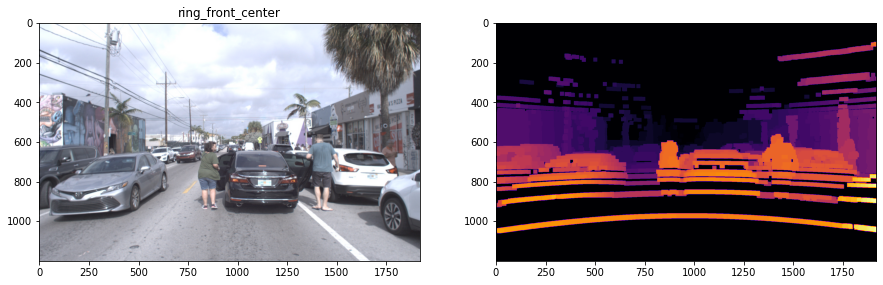

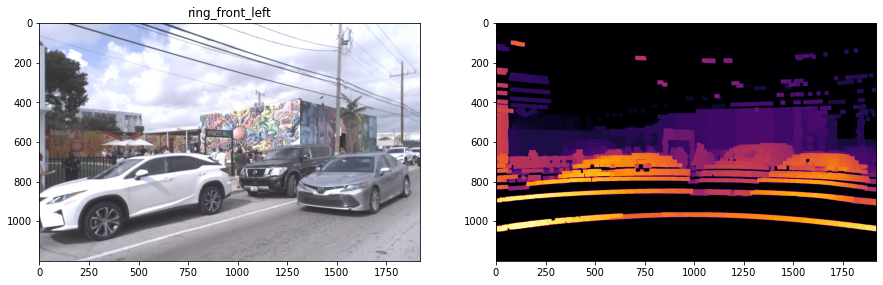

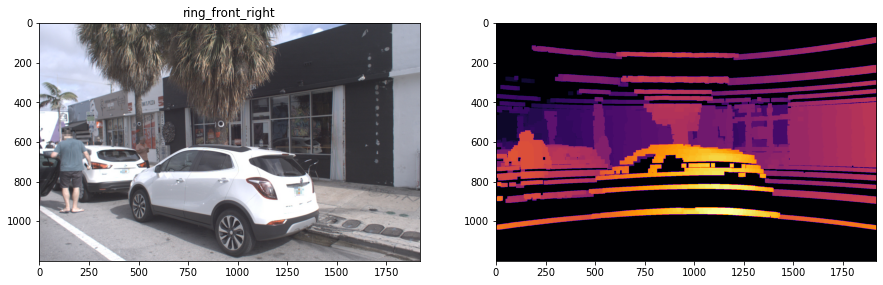

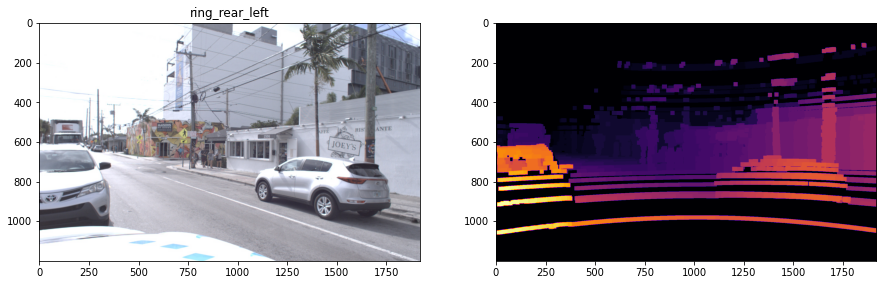

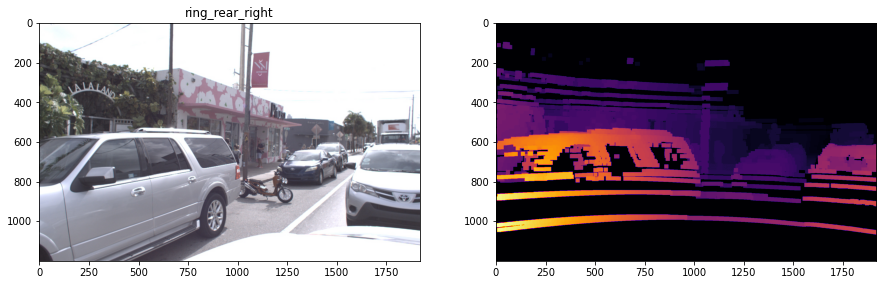

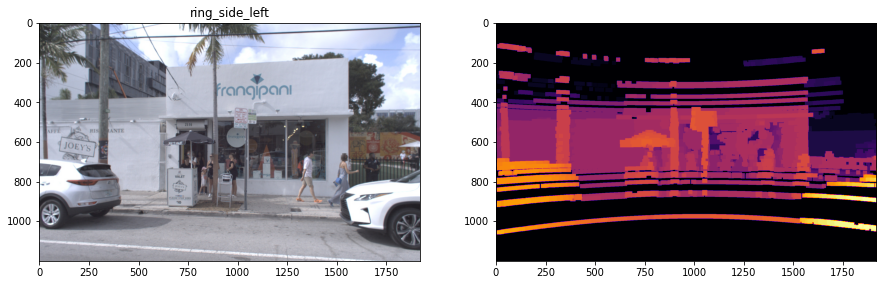

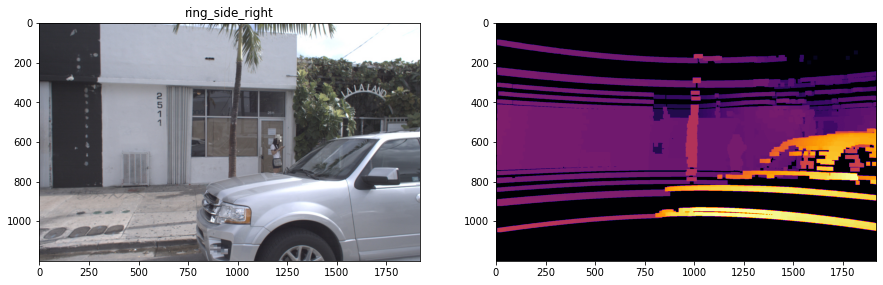

In [7]:
def display_depthmap(img_name: str, log_id: str, data_path: str) -> None:
    """
    For the provided image name, log_id and data_path (either train or val path)
    visualize depth map from all the ring cameras
    
    """
    for camera_name in RING_CAMERA_LIST:
        # Load images
        rgb_image_path = os.path.join(data_path, "rgb", log_id, camera_name, img_name)
        depth_image_path = os.path.join(data_path, "depth", log_id, camera_name, img_name)
        rgb_image = cv2.cvtColor(
            cv2.imread(rgb_image_path, cv2.IMREAD_UNCHANGED), cv2.COLOR_BGR2RGB
        )
        depth_image = cv2.imread(depth_image_path, cv2.IMREAD_UNCHANGED) / 256
        
        # Dilate for better visualization
        dilated_depth_image = cv2.dilate(
            depth_image, kernel=np.ones((2, 2), np.uint8), iterations=20
        )
        plt.figure(figsize=(15, 7))
        plt.subplot(121)
        plt.imshow(rgb_image)
        plt.title(camera_name)
        plt.subplot(122)
        plt.imshow(dilated_depth_image, cmap="inferno")
        plt.show()

# Modify if needed
img_name = "30.png"
log_id = "043aeba7-14e5-3cde-8a5c-639389b6d3a6"
data_path = f"{output_save_path}/train/"
display_depthmap(img_name, log_id, data_path)